In [0]:

# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

https://github.com/S-Tabor/udacity-image-classifier-project/blob/master/Image%20Classifier%20Project.ipynb


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_dir = '/content/drive/My Drive/Colab Notebooks/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir ,transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(validation_data, batch_size =64,shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 20, shuffle = True)

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
structures = {"vgg16":25088,
              "densenet121" : 1024,
              "alexnet" : 9216 }

In [0]:
def nn_setup(structure='vgg16',dropout=0.5, hidden_layer1 = 120,lr = 0.001):
    
    
    if structure == 'vgg16':
        model = models.vgg16(pretrained=True)        
    elif structure == 'densenet121':
        model = models.densenet121(pretrained=True)
    elif structure == 'alexnet':
        model = models.alexnet(pretrained = True)
    else:
        print("Im sorry but {} is not a valid model.Did you mean vgg16,densenet121,or alexnet?".format(structure))
        
    
        
    for param in model.parameters():
        param.requires_grad = False

        from collections import OrderedDict
        classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(dropout)),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
        
        model.classifier = classifier
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.classifier.parameters(), lr )
        
        
        return model , optimizer ,criterion 

   

In [0]:
model,optimizer,criterion = nn_setup('vgg16')

In [0]:
# Implement a function for the validation pass

def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    
    # change model to work with cuda
    model.to('cuda')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):
    
        # Change images and labels to work with cuda
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)
        
        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [0]:
epochs = 5
steps = 0
print_every = 40

# change to gpu mode
model.to('cuda')

for e in range(epochs):

    running_loss = 0
    
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # zeroing parameter gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()
            
            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
                
            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Valid Loss: {round(valid_loss/len(validloader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")
            
            running_loss = 0
            
            # Turning training back on
            model.train()
           

In [0]:
correct = 0
total = 0
model.to('cuda')


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

Test accuracy of model: 72.283%


In [0]:
# Saving: feature weights, new classifier, index-to-class mapping, optimiser state, and No. of epochs

checkpoint = {'state_dict': model.state_dict(),
              'classifier': model.classifier,
              'class_to_idx': train_data.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs}

torch.save(checkpoint, '/content/drive/My Drive/Colab Notebooks/my_checkpoint1.pth')

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    # Checkpoint for when using GPU
    checkpoint = torch.load(filepath)
    
    # Checkpoint for when using CPU
    #checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    
    model.load_state_dict(checkpoint['state_dict'])
    model.classifier = checkpoint['classifier'] 
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [0]:

# Loading model
model = load_checkpoint('/content/drive/My Drive/Colab Notebooks/my_checkpoint1.pth')

# Checking model i.e. should have 102 output units in the classifier
print(model)

RuntimeError: ignored

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]) 
    
    ## Transforming image for use with network
    pil_tfd = transform(pil_im)
    
    # Converting to Numpy array 
    array_im_tfd = np.array(pil_tfd)
    
    return array_im_tfd

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


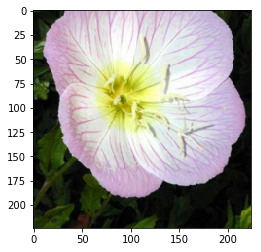

In [0]:
imshow(process_image(data_dir + 'bmw 3 2019'))

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file   
    
    # Loading model - using .cpu() for working with CPUs
    loaded_model = load_checkpoint(model).cpu()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)

    # Calculating probabilities
    probs = torch.exp(output)
    probs_top = probs.topk(topk)[0]
    index_top = probs.topk(topk)[1]
    
    # Converting probabilities and outputs to lists
    probs_top_list = np.array(probs_top)[0]
    index_top_list = np.array(index_top[0])
    
    # Loading index and class mapping
    class_to_idx = loaded_model.class_to_idx
    # Inverting index-class dictionary
    indx_to_class = {x: y for y, x in class_to_idx.items()}

    # Converting index list to class list
    classes_top_list = []
    for index in index_top_list:
        classes_top_list += [indx_to_class[index]]
        
    return probs_top_list, classes_top_list

In [0]:
# Testing predict function

# Inputs are paths to saved model and test image
model_path = '/content/drive/My Drive/Colab Notebooks/my_checkpoint1.pth'
image_path = data_dir + '/test' + '/11/' + 'image_03141'

probs,classes = predict(image_path, model_path, topk=5)

print(probs)
print(classes)

[0.9524606  0.01490607 0.01051194 0.00740338 0.00578711]
['11', '72', '4', '74', '94']


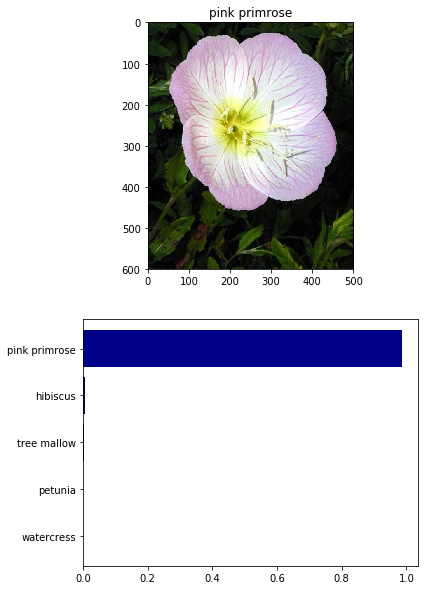

In [0]:
# TODO: Display an image along with the top 5 classes

# Inputs: paths to saved model and test image
model_path = '/content/drive/My Drive/Colab Notebooks/my_checkpoint1.pth'
#image_path = data_dir + '/test' + '/11/' + 'image_03141'

# Other images to try:
# image_path = data_dir + '/test' + '/102/' + 'image_08004'
# image_path = data_dir + '/test' + '/46/' + 'image_01077'
# image_path = data_dir + '/test' + '/73/' + 'image_00401'
# image_path = data_dir + '/test' + '/66/' + 'image_05549'
image_path = data_dir + '/test' + '/1/'+ 'image_06743'

# Getting prediction
probs,classes = predict(image_path, model_path, topk=5)

# Uncomment to check if the class of flower (as seen from the file path) matches the top one predicted:
#print(classes[0])

# Converting classes to names
names = []
for i in classes:
    names += [cat_to_name[i]]

# Creating PIL image
image = Image.open(image_path+'.jpg')

# Plotting test image and predicted probabilites
f, ax = plt.subplots(2,figsize = (6,10))

ax[0].imshow(image)
ax[0].set_title(names[0])

y_names = np.arange(len(names))
ax[1].barh(y_names, probs, color='darkblue')
ax[1].set_yticks(y_names)
ax[1].set_yticklabels(names)
ax[1].invert_yaxis() 

plt.show()



# Uncomment below to see the transformed image on which the model based its prediction
#imshow(process_image(image_path), ax=None, title=None)
